In [1]:
import tensorflow as tf
import numpy as np

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 数据准备

In [2]:
corpus = ['king is a strong man',
          'queen is a wise woman',
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong',
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

# 数据预处理

去除一些停止词：

In [10]:
def remove_stop_words(corpus):
    stop_words = set(['is', 'a', 'will', 'be'])
    return [" ".join([word for word in text.split() if word not in stop_words]) for text in corpus]


corpus = remove_stop_words(corpus)
print(corpus)

['king strong man', 'queen wise woman', 'boy young man', 'girl young woman', 'prince young king', 'princess young queen', 'man strong', 'woman pretty', 'prince boy king', 'princess girl queen']


找出词语的集合：

In [4]:
words_set = set()
for text in corpus:
    for word in text.split(' '):
        words_set.add(word)

# words_set

维护一个word-number的映射表，使用字典实现：

In [5]:
word2int=dict()
int2word=dict()
for idx,word in enumerate(words_set):
    word2int[word]=idx
    int2word[idx]=word

# word2int

使用滑动窗口生成数据：

In [6]:
WINDOW_SIZE = 2    # 中心词与左右边界的距离
center_words = list()
context_words = list()

for text in corpus:
    words = text.split()
    for idx, center_word in enumerate(words):
        # 限定区域
        for context_word in words[max(0, idx-WINDOW_SIZE):min(idx+WINDOW_SIZE, len(words))+1]:
            if context_word != center_word:
                center_words.append(center_word)
                context_words.append(context_word)
                
print(center_words,context_words,sep='\n')

将数据转换成one-hot向量：

In [7]:
ONE_HOT_DIM = len(words_set)

def to_onehot(word):
    res=np.zeros(ONE_HOT_DIM)
    res[word2int[word]]=1
    return res

X_train=np.array(list(map(to_onehot,center_words)))
Y_train=np.array(list(map(to_onehot,context_words)))

# 网络设计
最简单的词嵌入模型是一个单隐层多输出的神经网络，输入层的单元数等于词库的大小，隐藏层单元数等于嵌入词向量的维度，输出层单元数仍然等于词库的大小。

In [8]:
unit_I = len(words_set)
unit_h1 = 2    # embedding size
unit_O = unit_I

# 搭建网络

In [9]:
# 输入必须是可由用户指定的，所以设为placeholder
X = tf.placeholder(tf.float32, [None, unit_I])
Y = tf.placeholder(tf.float32, [None, unit_O])

# 网络结构图
with tf.name_scope('WordEmb'):
    hidden1 = tf.layers.dense(X, unit_h1,
                              activation=None, name='emb')    # 隐层即嵌入层
    # 嵌入层与FC层的区别就在于，做嵌入需要的是参数，而FC层需要的输出
    with tf.variable_scope('emb', reuse=True):
        w = tf.get_variable("kernel")
        b = tf.get_variable("bias")

    logits = tf.layers.dense(hidden1, unit_O, activation=None)

# 评估子图
with tf.name_scope('Eval'):
    loss = tf.losses.softmax_cross_entropy(onehot_labels=Y, logits=logits)

# 优化图
with tf.name_scope('train_op'):
    lr = 1e-2
    train_op = tf.train.GradientDescentOptimizer(lr).minimize(loss)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
init = tf.global_variables_initializer()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [10]:
with tf.Session(config=config) as sess:
    sess.run(init)
    iteration = 10000
    
    for i in range(iteration):
        sess.run(train_op, feed_dict={X: X_train, Y: Y_train})
        if i % 2000 == 0:
            print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={X: X_train, Y: Y_train}))
            
    embs=sess.run(w+b)

iteration 0 loss is :  2.5260603
iteration 2000 loss is :  2.2669108
iteration 4000 loss is :  2.0499022
iteration 6000 loss is :  1.9456667
iteration 8000 loss is :  1.88323


<Figure size 432x288 with 0 Axes>

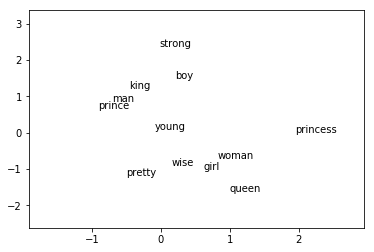

In [12]:
import matplotlib.pyplot as plt

plt.clf()
fig, ax = plt.subplots()

for idx,emb in enumerate(embs):
    ax.annotate(int2word[idx], emb)

PADDING = 1.0
x_axis_min = np.amin(embs, axis=0)[0] - PADDING
y_axis_min = np.amin(embs, axis=0)[1] - PADDING
x_axis_max = np.amax(embs, axis=0)[0] + PADDING
y_axis_max = np.amax(embs, axis=0)[1] + PADDING

plt.xlim(x_axis_min, x_axis_max)
plt.ylim(y_axis_min, y_axis_max)
plt.rcParams["figure.figsize"] = (10, 10)

plt.show()